In [79]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


a = np.array([0,2])
b = np.array([1,2])


a.tolist()

[0, 2]

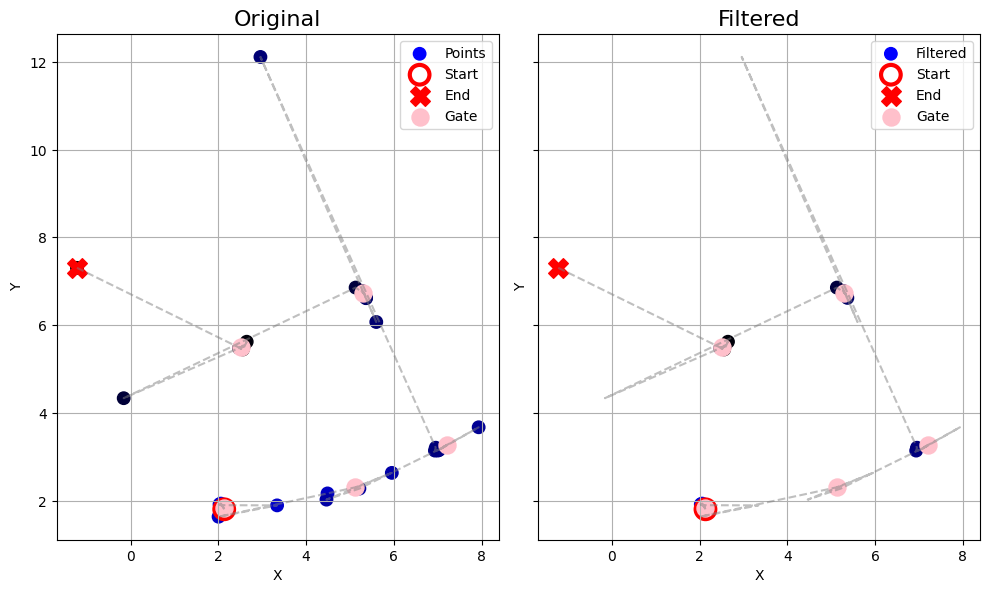

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 读取并筛选
df = pd.read_csv('target_positions.csv')
df_center = df[df['point_index'] == 4].sort_values('frame').reset_index(drop=True)
points = df_center[['x', 'y']].values
num_points = len(df_center)

# 2. 距离阈值
T = 0.5

# 3. 生成 mask：第一个点默认画出
mask = np.zeros(num_points, dtype=bool)
mask[0] = True
for i in range(1, num_points):
    dist = np.hypot(*(points[i] - points[i-1]))
    if dist < T:
        mask[i] = True

# 4. 构造颜色渐变
colors_all = [(0, 0, 1 - idx/(num_points - 1)) for idx in range(num_points)]
colors_filtered = [colors_all[i] for i in range(num_points) if mask[i]]

# 粉色“Gate”点
pink_points = np.array([
    [2.12, 1.84],
    [5.12, 2.30],
    [7.20, 3.27],
    [5.30, 6.74],
    [2.52, 5.50]
])

# 创建并排两个子图
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)
titles = ['Original', 'Filtered']

for ax, is_filtered, title in zip(axes, [False, True], titles):
    # 背景轨迹线
    ax.plot(df_center['x'], df_center['y'],
            linestyle='--', color='gray', alpha=0.5)
    
    # 散点
    if not is_filtered:
        ax.scatter(points[:,0], points[:,1],
                   c=colors_all, s=80, label='Points')
    else:
        df_plot = df_center[mask].reset_index(drop=True)
        ax.scatter(df_plot['x'], df_plot['y'],
                   c=colors_filtered, s=80, label='Filtered')
    
    # 起点/终点
    ax.scatter(points[0,0], points[0,1],
               s=200, facecolors='none', edgecolors='red',
               marker='o', linewidths=3, label='Start')
    ax.scatter(points[-1,0], points[-1,1],
               s=200, color='red', marker='X',
               linewidths=1, label='End')
    
    # Gate 点
    ax.scatter(pink_points[:, 0], pink_points[:, 1],
               color='pink', marker='o', s=150, label='Gate')
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    ax.grid(True)
    # 改用 adjustable='box'，避免和 share 轴冲突
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


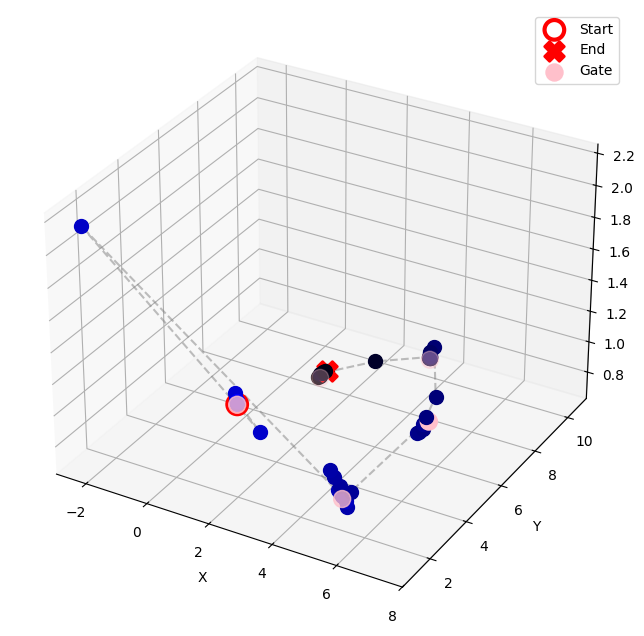

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # 导入 3D 绘图模块

# 读取 CSV 文件
df = pd.read_csv('target_positions.csv')

# 筛选 point_index 为 4 的数据，并按 frame 排序
df_center = df[df['point_index'] == 4].sort_values('frame').reset_index(drop=True)
num_points = len(df_center)

# 构造颜色列表：颜色从蓝色到黑色（RGB: (0,0,1) 到 (0,0,0)）
colors = [(0, 0, 1 - idx/(num_points - 1)) for idx in range(num_points)]

# 创建 3D 图形
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制连线表示轨迹（灰色虚线）
ax.plot(df_center['x'], df_center['y'], df_center['z'], linestyle='--', color='gray', alpha=0.5)

# 绘制所有点（采样点），使用渐变颜色
for idx, row in df_center.iterrows():
    color = colors[idx]
    ax.scatter(row['x'], row['y'], row['z'], color=color, s=100)

# 标注起点（第一个点，用红色圆圈标注）
start = df_center.iloc[0]
ax.scatter(start['x'], start['y'], start['z'], s=200, facecolors='none',
           edgecolors='red', marker='o', linewidths=3, label='Start')

# 标注终点（最后一个点，用红色叉号标注）
end = df_center.iloc[-1]
ax.scatter(end['x'], end['y'], end['z'], s=200, color='red', marker='X', linewidths=2, label='End')

# 用粉色标注预设的五个点
# 给定的五个点（X, Y, Z 坐标）
pink_points = np.array([
    [2.12, 1.84, 1.24],
    [5.12, 2.30, 0.78],
    [7.20, 3.27, 1.29],
    [5.30, 6.74, 1.19],
    [2.52, 5.50, 1.04]
])
# 绘制粉色点，并加上标签
ax.scatter(pink_points[:, 0], pink_points[:, 1], pink_points[:, 2], 
           color='pink', marker='o', s=150, label='Gate')

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.legend()
plt.show()


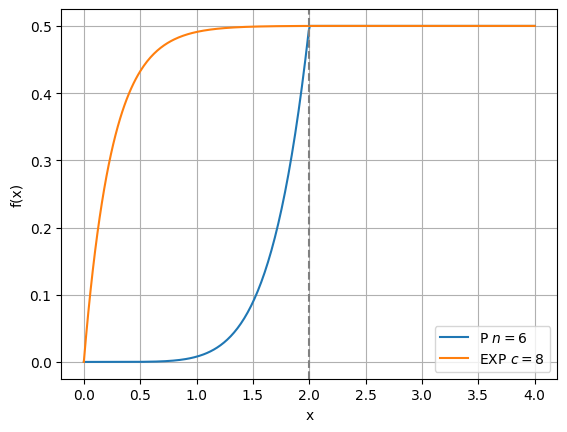

In [51]:
import numpy as np

def f_poly(x, T, n=4):
    """
    多项式型：
      x>=T    -> 0.5
      0<=x<T  -> 0.5*(x/T)^n
      x<0     -> 0
    n 越大，衰减越陡。
    """
    x = np.asarray(x, dtype=float)
    f = np.zeros_like(x)
    mask1 = x >= T
    mask2 = (x >= 0) & (x < T)
    f[mask1] = 0.5
    f[mask2] = 0.5 * (x[mask2] / T)**n
    return f

import numpy as np

def f_exp(x, T, c=5):
    """
    指数型：
      x>=T    -> 0.5
      0<=x<T  -> 0.5 * (1 - exp(-c*(x/T))) / (1 - exp(-c))
      x<0     -> 0
    c 越大，衰减越陡。
    """
    x = np.asarray(x, dtype=float)
    f = np.zeros_like(x)
    mask1 = x >= T
    mask2 = (x >= 0) & (x < T)
    f[mask1] = 0.5
    denom = 1 - np.exp(-c)
    f[mask2] = 0.5 * (1 - np.exp(-c * (x[mask2] / T))) / denom
    return f

import matplotlib.pyplot as plt

T = 2.0
xs = np.linspace(0, 4, 400)

plt.plot(xs, f_poly(xs, T, n=6),  label='P $n=6$')
plt.plot(xs, f_exp(xs, T, c=8),   label='EXP $c=8$')
plt.axvline(T, color='gray', linestyle='--')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()
